In [1]:
from collections import OrderedDict
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from robotpy_apriltag import AprilTagDetector, AprilTagPoseEstimator, AprilTagDetection

In [80]:
paths = [
    ".\\data\\apriltags_test\\best_case.png",
    ".\\data\\apriltags_test\\higher.png",
    ".\\data\\apriltags_test\\highest.tif",
]
paths_cross_ref = [
    ".\\data\\apriltags_test\\highest_cross_ref\\IMG_0259_1.tif",
    ".\\data\\apriltags_test\\highest_cross_ref\\IMG_0259_2.tif",
    ".\\data\\apriltags_test\\highest_cross_ref\\IMG_0259_3.tif",
    ".\\data\\apriltags_test\\highest_cross_ref\\IMG_0259_4.tif",
    ".\\data\\apriltags_test\\highest_cross_ref\\IMG_0259_5.tif",
]
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in paths]
images_cross_ref = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in paths_cross_ref]

In [91]:
families = [
    "tag16h5",
    "tag25h9",
    "tagStandard41h12"
]
detectors: List[AprilTagDetector] = []
for family in families:
    d = AprilTagDetector()
    d.addFamily(family)
    config = AprilTagDetector.Config()
    config.quadDecimate = 1.0
    config.numThreads = 4
    config.refineEdges = 1.0
    d.setConfig(config)
    detectors.append(d)

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(detectors)))

In [125]:
def verify_detections(tag) -> bool:
    valid_ids = [0, 4, 9]
    return tag.getId() in valid_ids

In [134]:
def detect_tags(img, show_id=False):
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    for detector, color in zip(detectors, colors):
        tags: List[AprilTagDetection] = detector.detect(img)
        for tag in tags:
            if not verify_detections(tag):
                continue
            plt.scatter(tag.getCenter().x, tag.getCenter().y, marker="o", color=color, s=20, label=tag.getFamily())
            if show_id:
                plt.text(tag.getCenter().x + 50, tag.getCenter().y - 50, tag.getId(), color="black", ha="center",
                     va="center",
                     bbox=dict(boxstyle="round",
                               ec=(1., 0.5, 0.5),
                               fc=(1., 0.8, 0.8),
                               ))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

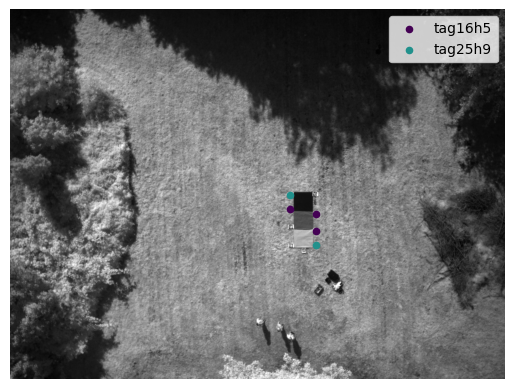

In [135]:
detect_tags(images[2])

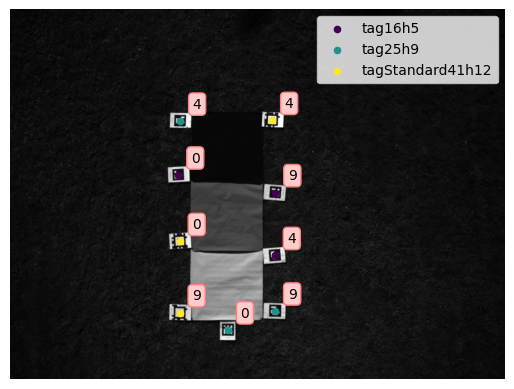

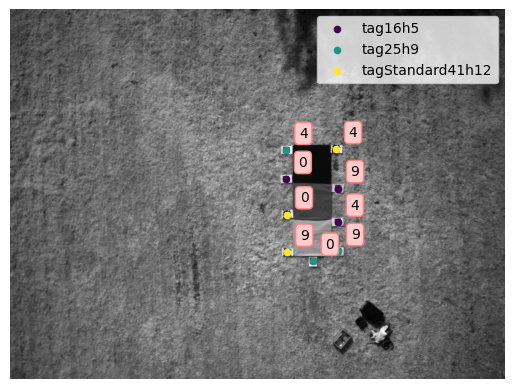

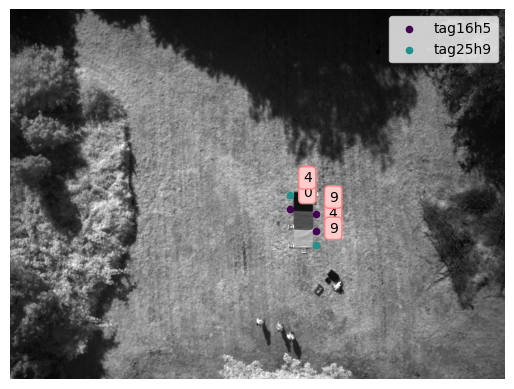

In [132]:
for i, img in enumerate(images):
    detect_tags(img)

## Cross Referencing between Bands

In [95]:
def detect_tags_cross_reference(imgs):
    plt.imshow(imgs[1], cmap="gray")
    plt.axis("off")
    for img in imgs:
        for detector, color in zip(detectors, colors):
            tags: List[AprilTagDetection] = detector.detect(img)
            for tag in tags:
                plt.scatter(tag.getCenter().x, tag.getCenter().y, marker="o", color=color, s=20, label=tag.getFamily())
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

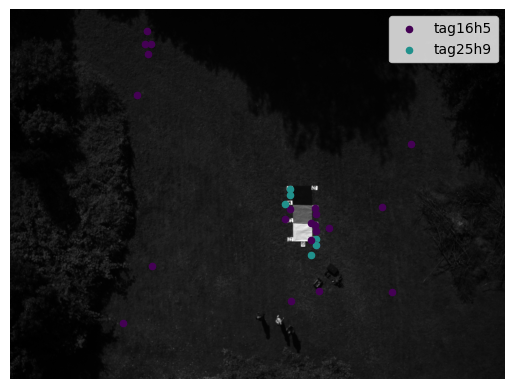

In [96]:
detect_tags_cross_reference(images_cross_ref)

## 3D Pose Estimation

In [97]:
horizontal_focal_length_pixels = 1581.7867974691412
horizontal_focal_center_pixels = 678.6724626822399
vertical_focal_length_pixels = 1581.7867974691412
vertical_focal_center_pixels = 529.4318832108801
tag_size = 0.2

In [98]:
pose_estimator = AprilTagPoseEstimator(
    AprilTagPoseEstimator.Config(tag_size, horizontal_focal_length_pixels, vertical_focal_length_pixels,
                                 horizontal_focal_center_pixels, vertical_focal_center_pixels))


def post_estimate_tags(img):
    fig_3d = plt.figure()
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    ax_3d.axis("off")
    for detector, color in zip(detectors, colors):
        tags: List[AprilTagDetection] = detector.detect(img)
        for tag in tags:
            estimate = pose_estimator.estimate(tag)
            ax_3d.scatter(tag.getCenter().x, tag.getCenter().y, marker="o", color=color, s=20)
            # Define the origin point in 3D
            origin = np.array([tag.getCenter().x, tag.getCenter().y, 0])
            # Plot the 3D pose estimate
            ax_3d.quiver(origin[0], origin[1], origin[2], estimate.x, estimate.y, estimate.z, length=.01)
    fig_3d.show()

C:\Users\ninja\AppData\Local\Temp\ipykernel_14444\3550042191.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_3d.show()


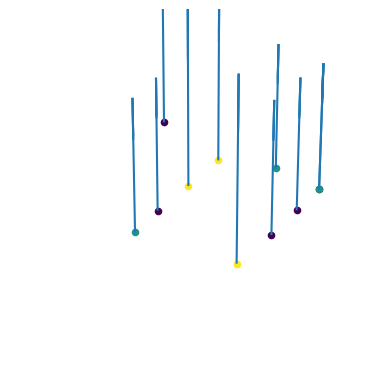

In [101]:
post_estimate_tags(images[0])    